# Google Colab 한글 폰트 설치

In [1]:
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

In [2]:
# 필요한 패키지
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy import linalg as la
import scipy.stats as ss
import scipy.special

# 한글출력
plt.rcParams['font.family'] = 'Malgun Gothic' #  Windows 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# 필요한 패키지 2
from pgmpy.factors.discrete import JointProbabilityDistribution as JPD
import sympy

scipy.__version__

'1.15.2'

- 테스트

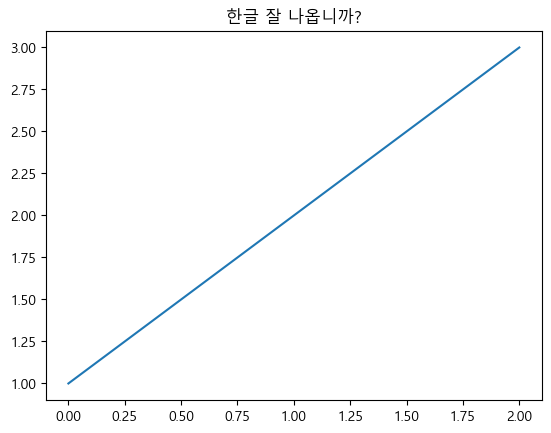

In [3]:
plt.plot([1, 2, 3])
plt.title("한글 잘 나옵니까?")
plt.show()

# SARIMAX 외생 변수

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
# from tqdm import tqdm_notebook
# from ipywidgets import IntProgress

from tqdm.auto import tqdm  # 일반 CLI용 progress bar
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## GDP 데이터
- realgdp : 실질 GDP (목표 변수 또는 내생 변수)
- realcons : 실질 개인 소비 지출
- realinv : 실질 국내 총 민간 투자
- realgovt : 실질 연방 소비 지출 및 투자
- realdpi : 실질 민간 가처분 소득
- cpi : 분기 말 소비자물가지수
- m1 : M1 명목 통화량
- tbilrate : 3개월 만기 국채의 분기별 월평균 금리
- unemp : 실업률
- pop : 분기 말 총 인구
- infl : 인플레이션율
- realint : 실질 이자율

In [5]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


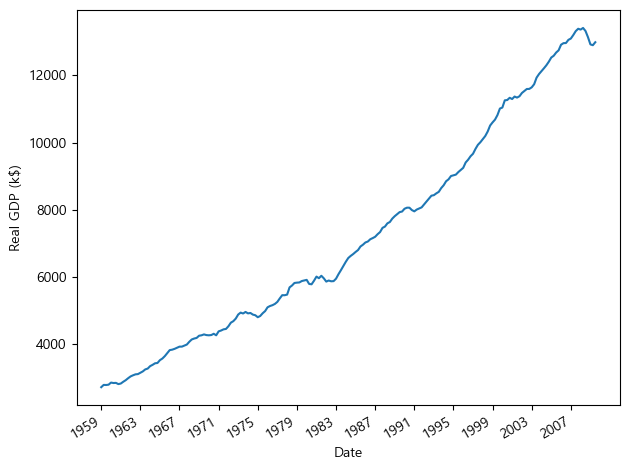

In [6]:
fig, ax = plt.subplots()

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

## 각 변수별 시각화

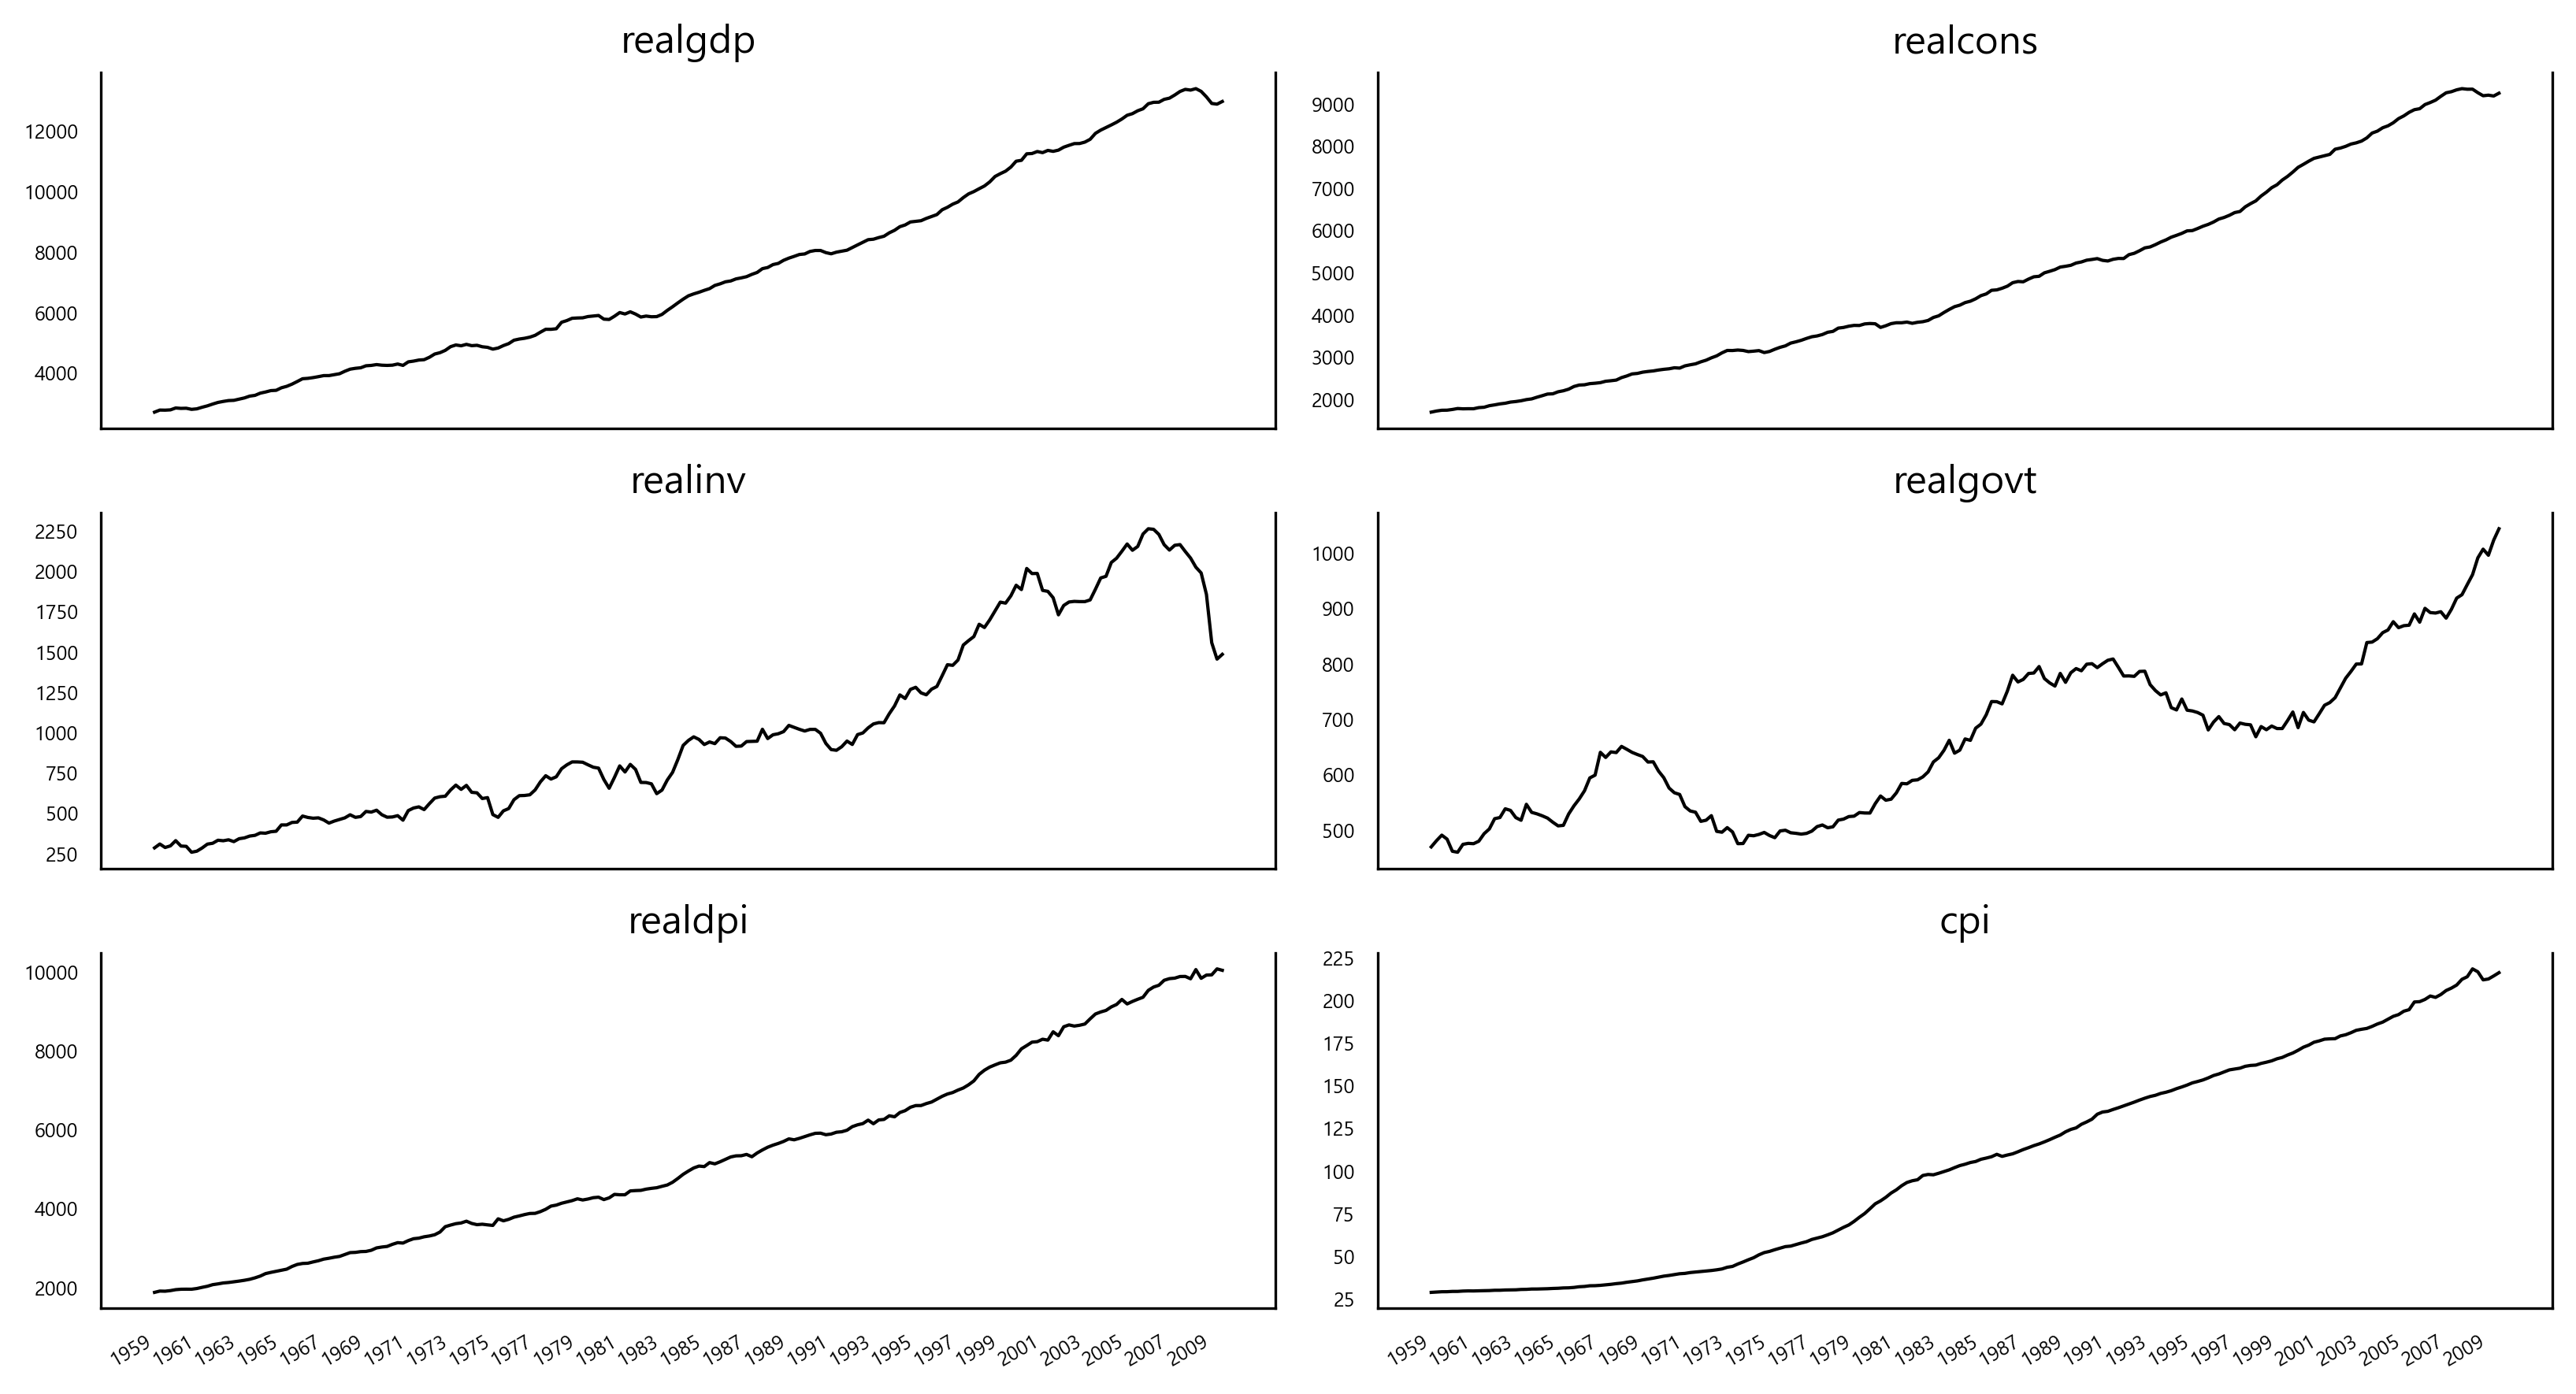

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))

for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]

    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

- 가설 세우기
  + realcons, realdpi, cpi가 잠재적으로 좋은 변수
  + realgovt와 realgdp는 더 약한 변수

## 변수 선택

In [8]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

## ADF 테스트

In [9]:
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647166
p-value: 0.9982455372335032


In [10]:
target_diff = target.diff() # pandas series 메서드

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08


## SARIMAX 모델 찾기
- 모델의 고유한 조합 피팅

In [12]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm(order_list):
        try:
            model = SARIMAX(
                endog, # 내생변수
                exog, # 외생변수
                order=(order[0], d, order[1]), # SARIMAX p, d, q
                seasonal_order=(order[2], D, order[3], s), # 계절성 있는가?
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

- 데이터가 분기별로 수집, m = 4
- 차분은 1회 진행
- p, q는 3,3이 최적합


In [13]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [14]:
target_train = target[:200]
exog_train = exog[:200]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",1742.841043
1,"(3, 3, 1, 0)",1744.966668
2,"(3, 3, 0, 1)",1744.998644
3,"(2, 2, 0, 0)",1745.458681
4,"(2, 2, 0, 1)",1746.303185
...,...,...
251,"(0, 2, 0, 0)",1761.579044
252,"(0, 3, 0, 0)",1762.317095
253,"(0, 0, 0, 0)",1764.754980
254,"(1, 0, 0, 0)",1765.379412


## 가장 좋은 모델 적합
-

In [15]:
best_model = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.421
Date:                Fri, 16 May 2025   AIC                           1742.841
Time:                        17:36:10   BIC                           1782.361
Sample:                             0   HQIC                          1758.836
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9663      0.045     21.626      0.000       0.879       1.054
realinv        1.0136      0.033     30.862      0.000       0.949       1.078
realgovt       0.7280      0.127      5.737      0.0

## 모델의 잔차 확인
- 백색소음처럼 추세가 없고, 일정한 분산을 보임
- 잔차의 분포는 정규분포에 매우 가까움

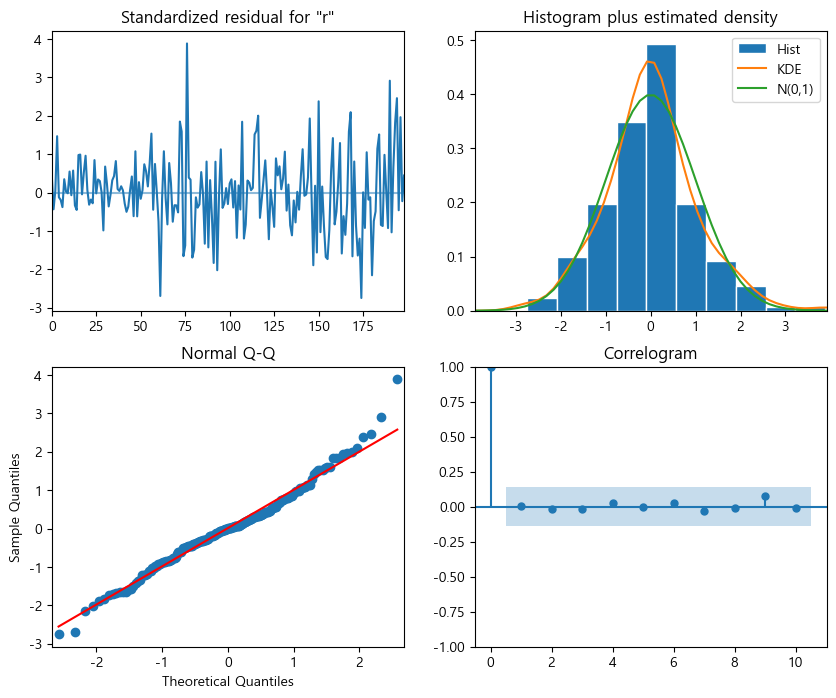

In [16]:
best_model_fit.plot_diagnostics(figsize=(10,8));

## 융-박스 테스트
- 잔차가 독립적이로 상관관계 없음
- p-value 0.05보다 큼

In [17]:
residuals = best_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.079588,0.777856
2,0.210164,0.900251
3,0.215508,0.975048
4,1.177038,0.881864
5,1.179258,0.946852
6,1.198125,0.976977
7,1.398744,0.985610
8,1.409827,0.994106
9,1.780236,0.994485
10,1.784917,0.997739


## 다음 시간 단계 여러 번 예측

In [18]:
def rolling_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'SARIMAX':
        pred_SARIMAX = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)

        return pred_SARIMAX

- 2008년부터 2009년 3분기까지의 다음 시간 단계 예측

In [19]:
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13344.064863
197,13415.266,13366.865,13373.512157
198,13324.600,13415.266,13378.802598
199,13141.920,13324.600,13327.777919
200,12925.410,13141.920,13133.834015
201,12901.504,12925.410,12886.451227
202,12990.341,12901.504,12873.791143


## 오차 확인

In [20]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

0.736849498653785 0.7041755323633658


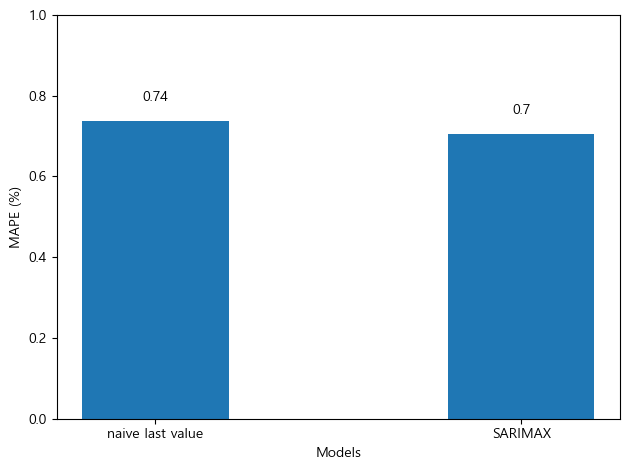

In [22]:
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

## 예측값 확인

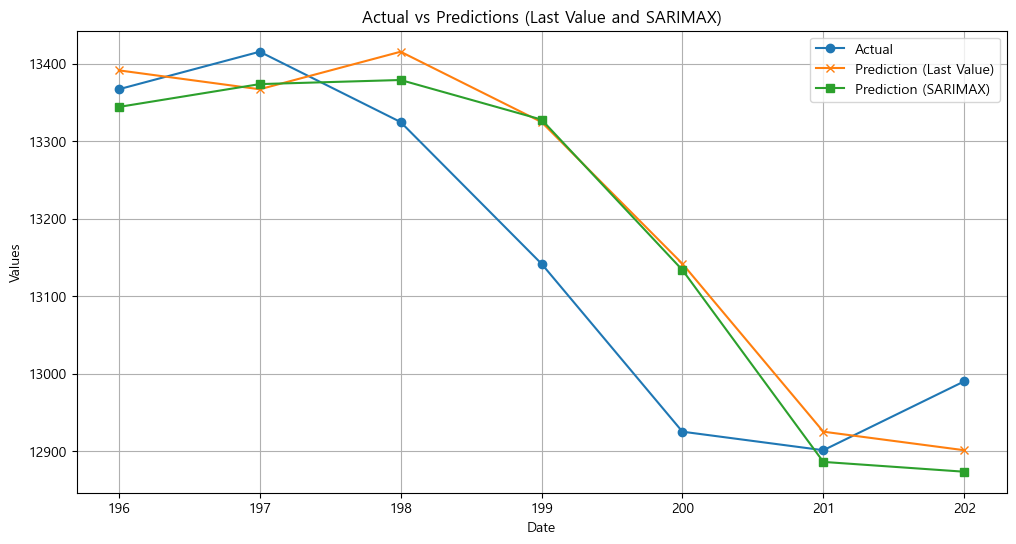

In [23]:
# Creating a figure and axis for further customization if needed
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the data on the created axis
ax.plot(pred_df['actual'], label='Actual', marker='o')
ax.plot(pred_df['pred_last_value'], label='Prediction (Last Value)', marker='x')
ax.plot(pred_df['pred_SARIMAX'], label='Prediction (SARIMAX)', marker='s')


# Customizing the plot
ax.set_title('Actual vs Predictions (Last Value and SARIMAX)')
ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.legend()
ax.grid(True)

# Display the chart
plt.show()